In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

In [2]:
"""
Open the training data.
"""
training_data_filepath = 'F:/ZaknafeinII_Backup_02-02-22/daea/training_data_generation/id16/output/mfcc_training_data_dict.pickle'

with open(training_data_filepath, 'rb') as f:
    data_dict = pickle.load(f)
    
for key in data_dict:
    print(key, 'is of shape', data_dict.get(key).shape)

train_input is of shape (180518, 64)
val_input is of shape (38683, 64)
test_input is of shape (38683, 64)
train_labels is of shape (180518, 64)
val_labels is of shape (38683, 64)
test_labels is of shape (38683, 64)


In [3]:
"""
Standardize/scale the data.
"""

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(np.concatenate((data_dict.get('train_input'),
                                   data_dict.get('val_input'),
                                   data_dict.get('test_input'),
                                   data_dict.get('train_labels'),
                                   data_dict.get('val_labels'),
                                   data_dict.get('test_labels'))))

overlap_train_scaled = min_max_scaler.transform(data_dict.get('train_input'))
overlap_val_scaled = min_max_scaler.transform(data_dict.get('val_input'))
overlap_test_scaled = min_max_scaler.transform(data_dict.get('test_input'))
character_train_scaled = min_max_scaler.transform(data_dict.get('train_labels'))
character_val_scaled = min_max_scaler.transform(data_dict.get('val_labels'))
character_test_scaled = min_max_scaler.transform(data_dict.get('test_labels'))

In [4]:
"""
Calculate the ideal masks such that (input vals)*(mask coefficients)=(label vals)
So --> (mask coefficients)=(label vals)/(input vals)
"""
# zero_count = 0
# minimum = -1
# for i in overlap_train_scaled:
#     for j in i:
#         if j == 0:
#             zero_count = zero_count + 1
#         if minimum == -1 and j != 0:
#             minimum = j
#         if j < minimum and j != 0:
#             minimum = j
# print(zero_count, minimum)

imask_train = np.divide(character_train_scaled, overlap_train_scaled)
imask_val = np.divide(character_val_scaled, overlap_val_scaled)
imask_test = np.divide(character_test_scaled, overlap_test_scaled)

C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_21308/438024550.py:17: RuntimeWarning: divide by zero encountered in true_divide
  imask_train = np.divide(character_train_scaled, overlap_train_scaled)
C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_21308/438024550.py:18: RuntimeWarning: divide by zero encountered in true_divide
  imask_val = np.divide(character_val_scaled, overlap_val_scaled)
C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_21308/438024550.py:19: RuntimeWarning: divide by zero encountered in true_divide
  imask_test = np.divide(character_test_scaled, overlap_test_scaled)
C:\Users\ZAKNAF~1\AppData\Local\Temp/ipykernel_21308/438024550.py:19: RuntimeWarning: invalid value encountered in true_divide
  imask_test = np.divide(character_test_scaled, overlap_test_scaled)


In [5]:
"""
Given overlap, predict imask.
"""

print('input shape:', overlap_train_scaled.shape)
print('input contains NaN values?:', np.any(np.isnan(overlap_train_scaled)))
print('input contains inf values?:', np.any(np.isinf(overlap_train_scaled)))
print('input datatype:', overlap_train_scaled.dtype)
overlap_train_scaled = overlap_train_scaled.astype('float32')
print('output shape:', imask_train.shape)
print('output contains NaN values?:', np.any(np.isnan(imask_train)))
print('output contains inf values?:', np.any(np.isinf(imask_train)))
imask_train[np.isinf(imask_train)] = 0
print('output contains inf values?:', np.any(np.isinf(imask_train)))


input shape: (180518, 64)
input contains NaN values?: False
input contains inf values?: False
input datatype: float32
output shape: (180518, 64)
output contains NaN values?: False
output contains inf values?: True
output contains inf values?: False


In [6]:
# """
# https://machinelearningmastery.com/multi-output-regression-models-with-python/
# """

# model_list = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor()]

# for model_type in model_list:
#     # define model
#     model = model_type
#     # fit model
#     model.fit(overlap_train_scaled, imask_train)

#     x = overlap_test_scaled[0]
#     y = imask_test[0]
#     yhat = model.predict([x])[0]

#     x_axis_list = list(range(0, len(x)))
#     plt.plot(x_axis_list, y)
#     plt.plot(x_axis_list, yhat)
#     plt.title(str(model_type))
#     plt.show()

In [7]:
"""
Prepare the training input and target output data
Using "target" with regression and "label" with classification is a a good idea
"""
train = np.concatenate((overlap_train_scaled, overlap_val_scaled))
target = np.concatenate((imask_train, imask_val))

print('train contains NaN values?:', np.any(np.isnan(train)))
print('train contains inf values?:', np.any(np.isinf(train)))
# print('input datatype:', overlap_train_scaled.dtype)
# overlap_train_scaled = overlap_train_scaled.astype('float32')
print('target shape:', target.shape)
print('target contains NaN values?:', np.any(np.isnan(target)))
print('target contains inf values?:', np.any(np.isinf(target)))
target[np.isinf(target)] = 0
print('target contains inf values?:', np.any(np.isinf(target)))

train contains NaN values?: False
train contains inf values?: False
target shape: (219201, 64)
target contains NaN values?: False
target contains inf values?: True
target contains inf values?: False


In [8]:
"""
Neural network time.
Basing work off of the following link:
https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
https://towardsdatascience.com/how-to-build-a-neural-network-for-voice-classification-5e2810fe1efa
"""
from keras.layers import Dense, Dropout, Activation, Flatten


NN_model = Sequential()

# The Input Layer :
# expecting 64 input dimensions
NN_model.add(Dense(64, kernel_initializer='normal', input_dim = 64, activation='relu'))

# The Hidden Layers :
# NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
# NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# just a single 128 is our best looking graph so far
# NN_model.add(Dropout(0.1))
NN_model.add(Dense(128, activation = 'relu'))
# NN_model.add(Dropout(0.15))
NN_model.add(Dense(128, activation = 'relu'))
# NN_model.add(Dropout(0.25))

# The Output Layer :
# changing the output dimensions from 1 to 64
NN_model.add(Dense(64, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
Total params: 37,248
Trainable params: 37,248
Non-trainable params: 0
_________________________________________________________________


In [10]:
"""
Only save the best form of the model throughout the training process.
https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

Notes:
- look into pruning during training
- explore this link: https://towardsdatascience.com/how-to-build-a-neural-network-for-voice-classification-5e2810fe1efa
  - has dropout layers
  - has graph to show performance over time during training
  - has early stopping
  - has layers to study
- train with GPU somehow
- better data preprocessing
"""
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

NN_model.fit(train, 
             target, 
             epochs=512, 
             batch_size=256, 
             validation_split = 0.2, 
#              callbacks=callbacks_list, 
             shuffle=True
            )

Epoch 1/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0856 - mean_absolute_error: 0.0856 - val_loss: 0.0932 - val_mean_absolute_error: 0.0932
Epoch 2/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0855 - mean_absolute_error: 0.0855 - val_loss: 0.0941 - val_mean_absolute_error: 0.0941
Epoch 3/512
685/685 [==============================] - 2s 2ms/step - loss: 0.0855 - mean_absolute_error: 0.0855 - val_loss: 0.0924 - val_mean_absolute_error: 0.0924
Epoch 4/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0855 - mean_absolute_error: 0.0855 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 5/512
685/685 [==============================] - 2s 2ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939
Epoch 6/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0854 - mean_absolute_error: 0.0854 - val_loss: 0.0936 - val_mean_absolute_error: 0.0936
Epoch 7/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0843 - mean_absolute_error: 0.0843 - val_loss: 0.0935 - val_mean_absolute_error: 0.0935
Epoch 51/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0843 - mean_absolute_error: 0.0843 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 52/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.0842 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 53/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.0842 - val_loss: 0.0927 - val_mean_absolute_error: 0.0927
Epoch 54/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.0842 - val_loss: 0.0916 - val_mean_absolute_error: 0.0916
Epoch 55/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0842 - mean_absolute_error: 0.0842 - val_loss: 0.0931 - val_mean_absolute_error: 0.0931
Epoch 56/512
685/

685/685 [==============================] - 2s 3ms/step - loss: 0.0837 - mean_absolute_error: 0.0837 - val_loss: 0.0937 - val_mean_absolute_error: 0.0937
Epoch 100/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0837 - mean_absolute_error: 0.0837 - val_loss: 0.0913 - val_mean_absolute_error: 0.0913
Epoch 101/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0837 - mean_absolute_error: 0.0837 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 102/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0837 - mean_absolute_error: 0.0837 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 103/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 104/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0836 - mean_absolute_error: 0.0836 - val_loss: 0.0920 - val_mean_absolute_error: 0.0920
Epoch 105/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0834 - mean_absolute_error: 0.0834 - val_loss: 0.0924 - val_mean_absolute_error: 0.0924
Epoch 149/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 150/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0926 - val_mean_absolute_error: 0.0926
Epoch 151/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0920 - val_mean_absolute_error: 0.0920
Epoch 152/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 153/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0833 - mean_absolute_error: 0.0833 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 154/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0831 - mean_absolute_error: 0.0831 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 198/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 199/512
685/685 [==============================] - 2s 2ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 200/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0917 - val_mean_absolute_error: 0.0917
Epoch 201/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 202/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 203/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0916 - val_mean_absolute_error: 0.0916
Epoch 247/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0919 - val_mean_absolute_error: 0.0919
Epoch 248/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 249/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 250/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0918 - val_mean_absolute_error: 0.0918
Epoch 251/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 252/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 296/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0925 - val_mean_absolute_error: 0.0925
Epoch 297/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0928 - val_mean_absolute_error: 0.0928
Epoch 298/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0916 - val_mean_absolute_error: 0.0916
Epoch 299/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0928 - val_mean_absolute_error: 0.0928
Epoch 300/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0826 - mean_absolute_error: 0.0826 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 301/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0825 - mean_absolute_error: 0.0825 - val_loss: 0.0922 - val_mean_absolute_error: 0.0922
Epoch 345/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 346/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0926 - val_mean_absolute_error: 0.0926
Epoch 347/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 348/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0917 - val_mean_absolute_error: 0.0917
Epoch 349/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 350/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0822 - mean_absolute_error: 0.0822 - val_loss: 0.0920 - val_mean_absolute_error: 0.0920
Epoch 394/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0823 - mean_absolute_error: 0.0823 - val_loss: 0.0913 - val_mean_absolute_error: 0.0913
Epoch 395/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0823 - mean_absolute_error: 0.0823 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 396/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0822 - mean_absolute_error: 0.0822 - val_loss: 0.0914 - val_mean_absolute_error: 0.0914
Epoch 397/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0823 - mean_absolute_error: 0.0823 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 398/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0822 - mean_absolute_error: 0.0822 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 399/51

685/685 [==============================] - 3s 5ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 443/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 444/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0916 - val_mean_absolute_error: 0.0916
Epoch 445/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0909 - val_mean_absolute_error: 0.0909
Epoch 446/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0907 - val_mean_absolute_error: 0.0907
Epoch 447/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 448/51

685/685 [==============================] - 2s 3ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 492/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0911 - val_mean_absolute_error: 0.0911
Epoch 493/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0912 - val_mean_absolute_error: 0.0912
Epoch 494/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0915 - val_mean_absolute_error: 0.0915
Epoch 495/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0921 - val_mean_absolute_error: 0.0921
Epoch 496/512
685/685 [==============================] - 2s 3ms/step - loss: 0.0820 - mean_absolute_error: 0.0820 - val_loss: 0.0906 - val_mean_absolute_error: 0.0906
Epoch 497/51

(180518, 64)
(64,)
(64,)


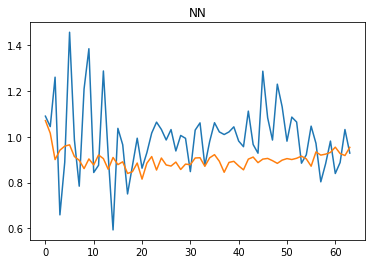

In [11]:
print(overlap_train_scaled.shape)
print(overlap_test_scaled[0].shape)
print(imask_test[0].shape)


x = overlap_test_scaled[0].reshape((1, 64))
y = imask_test[0]
yhat = NN_model.predict(x)

x_axis_list = list(range(0, 64))
plt.plot(x_axis_list, y)
plt.plot(x_axis_list, yhat[0])
plt.title(str("NN"))
plt.show()